In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/training_data.parquet')
df = df[df['label'] == 1]

# resume_embedds = pd.read_parquet('/content/drive/MyDrive/UserResumeEmbeddings.parquet')
# job_embedds = pd.read_parquet('/content/drive/MyDrive/JobEmbeddings.parquet')

resume_df = pd.read_csv('/content/drive/MyDrive/Resume.csv')
jobs_df = pd.read_parquet('/content/drive/MyDrive/processed_data.parquet')

In [ ]:
def analyze_job_domain(df, resume_df, jobs_df):
    # Total number of jobs in each domain (row count)
    jobs_per_domain = df.groupby("job_domain")["job_id"].count().reset_index(name="num_jobs")

    # Unique users in each domain
    unique_users = df.groupby("job_domain")["user_id"].nunique().reset_index(name="num_unique_users")

    # Unique jobs in each domain
    unique_jobs = df.groupby("job_domain")["job_id"].nunique().reset_index(name="num_unique_jobs")

    # Original unique users (from resume_df)
    ori_unique_users = resume_df.groupby('Category')['ID'].nunique().reset_index(name="ori_unique_users")

    # Original unique jobs (from jobs_df)
    ori_unique_jobs = jobs_df.groupby('parent_domain')['job_id'].nunique().reset_index(name="ori_unique_jobs")

    # Merge everything
    result = jobs_per_domain.merge(unique_users, on="job_domain")
    result = result.merge(unique_jobs, on="job_domain")

    # Merge with ori_unique_users and ori_unique_jobs (mapping Category -> job_domain)
    result = result.merge(ori_unique_users, left_on="job_domain", right_on="Category", how="left").drop("Category", axis=1)
    result = result.merge(ori_unique_jobs, left_on="job_domain", right_on="parent_domain", how="left").drop("parent_domain", axis=1)

    return result

# Example usage
result = analyze_job_domain(df, resume_df, jobs_df)

In [ ]:
result['percentage_jobs'] = result['num_unique_jobs'] / result['ori_unique_jobs']
result

,job_domain,num_jobs,num_unique_users,num_unique_jobs,ori_unique_users,ori_unique_jobs,percentage_jobs
0,ACCOUNTANT,44604,118,378,118,1921,0.196773
1,ADVOCATE,27258,118,231,118,1112,0.207734
2,AGRICULTURE,9198,63,146,63,1070,0.136449
3,APPAREL,26869,97,277,97,1585,0.174763
4,ARTS,28016,103,272,103,877,0.310148
5,AUTOMOBILE,17640,36,490,36,3080,0.159091
6,AVIATION,15444,117,132,117,837,0.157706
7,BANKING,18860,115,164,115,1133,0.144748
8,BPO,86218,22,3919,22,11013,0.355852
9,BUSINESS-DEVELOPMENT,65040,120,542,120,2083,0.260202


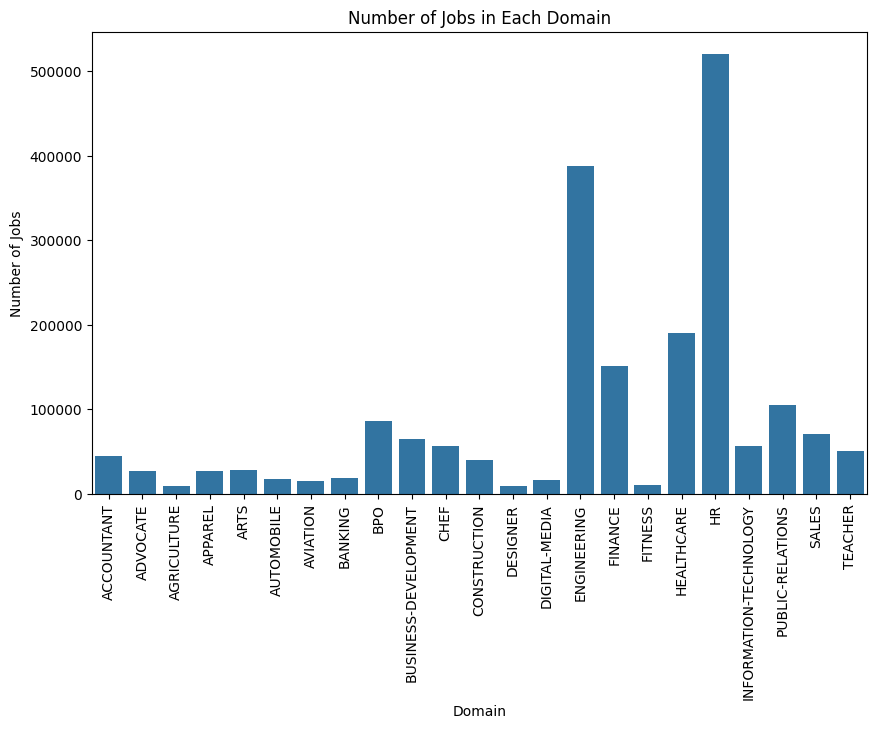

In [ ]:
# make a bar chart of the number of jobs in each domain
plt.figure(figsize=(10, 6))
sns.barplot(x='job_domain', y='num_jobs', data=result)
plt.title('Number of Jobs in Each Domain')
plt.xlabel('Domain')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=90)
plt.show()

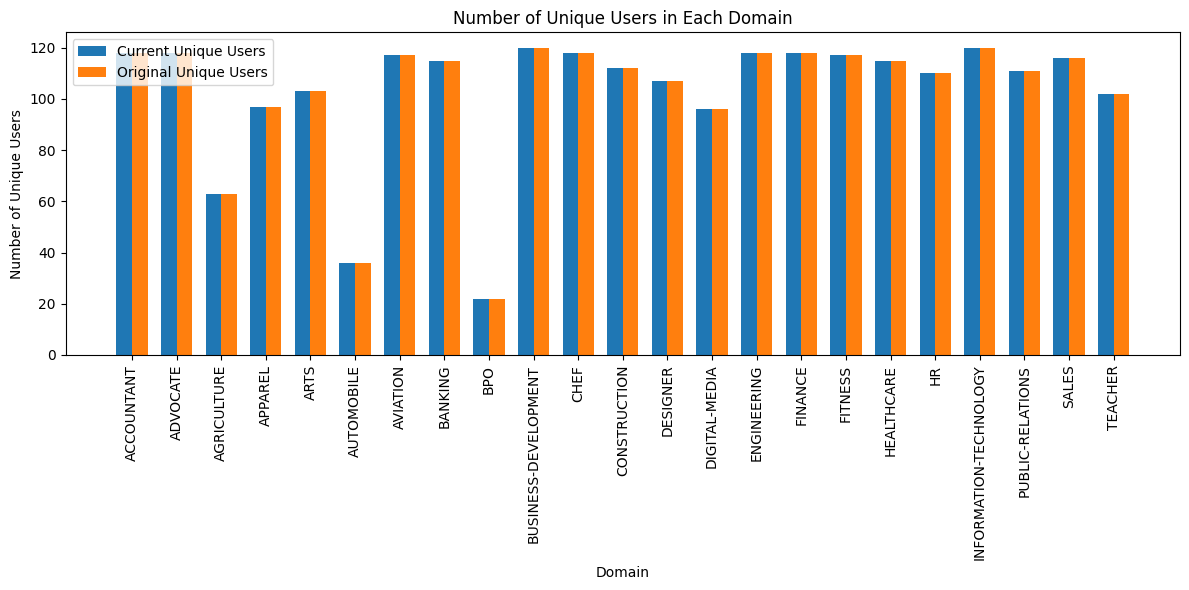

In [ ]:
# make a barchart representing both num_unique_users and ori_unique_users
plt.figure(figsize=(12, 6))
x = np.arange(len(result['job_domain']))
width = 0.35

plt.bar(x - width/2, result['num_unique_users'], width, label='Current Unique Users')
plt.bar(x + width/2, result['ori_unique_users'], width, label='Original Unique Users')

plt.title('Number of Unique Users in Each Domain')
plt.xlabel('Domain')
plt.ylabel('Number of Unique Users')
plt.xticks(x, result['job_domain'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

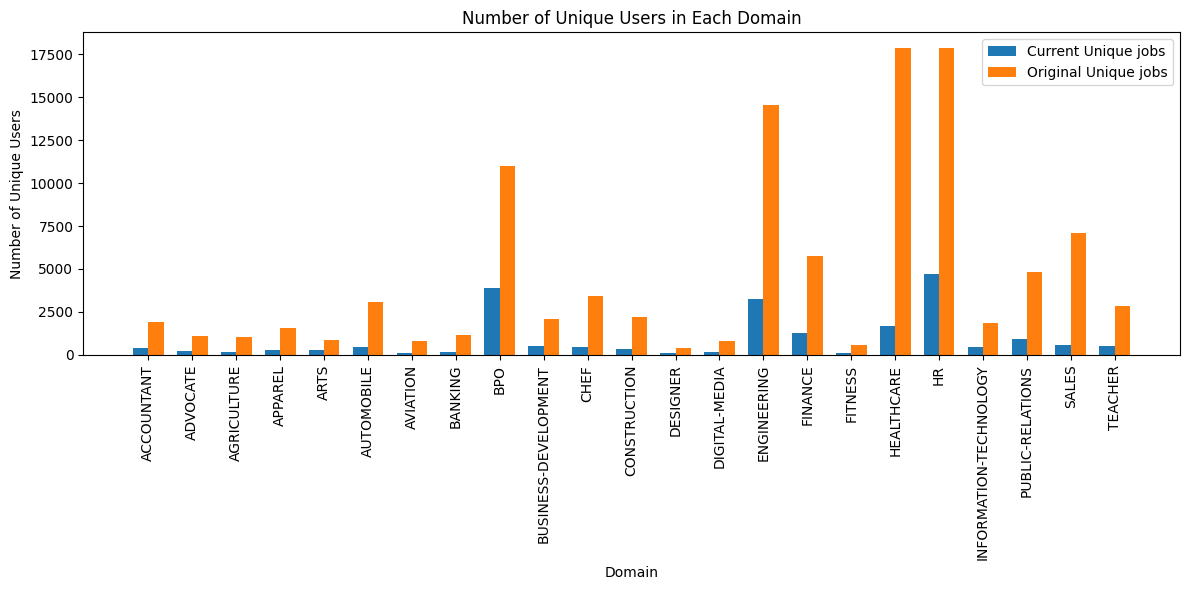

In [ ]:
# make a barchart representing both num_unique_jobs and ori_unique_jobs
plt.figure(figsize=(12, 6))
x = np.arange(len(result['job_domain']))
width = 0.35

plt.bar(x - width/2, result['num_unique_jobs'], width, label='Current Unique jobs')
plt.bar(x + width/2, result['ori_unique_jobs'], width, label='Original Unique jobs')

plt.title('Number of Unique Users in Each Domain')
plt.xlabel('Domain')
plt.ylabel('Number of Unique Users')
plt.xticks(x, result['job_domain'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def balance_job_distribution(df, jobs_df, target_variance=0.1, random_state=42):
    """
    Balances job distribution in interaction dataframe using ONLY new jobs from jobs_df.
    Distributes new jobs evenly across users within each domain.

    Args:
        df (pd.DataFrame): interaction dataframe with ['user_id','job_id','label','job_domain']
        jobs_df (pd.DataFrame): original jobs dataframe with ['job_id','parent_domain']
        target_variance (float): allowed variance in distribution (default ±5%)
        random_state (int): seed for reproducibility

    Returns:
        balanced_df (pd.DataFrame), dist_before (pd.Series), dist_after (pd.Series)
    """
    np.random.seed(random_state)

    # Distribution before balancing
    dist_before = df['job_domain'].value_counts()

    # Target range based on mean
    mean_count = int(dist_before.mean())
    min_target, max_target = int(mean_count*(1-target_variance)), int(mean_count*(1+target_variance))

    balanced_parts = []

    for domain, count in dist_before.items():
        domain_df = df[df['job_domain'] == domain].copy()

        if count > max_target:
            # Over-represented → downsample
            sampled = domain_df.sample(n=max_target, random_state=random_state)
            balanced_parts.append(sampled)

        elif count < min_target:
            # Under-represented → add new samples
            needed = min_target - count

            # Candidate new jobs from jobs_df (exclude existing jobs)
            candidate_jobs = jobs_df[jobs_df['parent_domain'] == domain][['job_id', 'parent_domain']].drop_duplicates()
            candidate_jobs = candidate_jobs.rename(columns={'parent_domain': 'job_domain'})

            existing_jobs = set(domain_df['job_id'].unique())
            candidate_jobs = candidate_jobs[~candidate_jobs['job_id'].isin(existing_jobs)]

            job_ids = candidate_jobs['job_id'].values
            if len(job_ids) > 0:
                # Users in this domain
                domain_users = list(domain_df['user_id'].unique())
                num_users = len(domain_users)

                # Number of jobs to actually add
                add_n = min(needed, len(job_ids))

                new_records = []
                for i in range(add_n):
                    user = domain_users[i % num_users]   # distribute evenly across users
                    job = job_ids[i]
                    new_records.append([user, job, 1, domain])

                new_df = pd.DataFrame(new_records, columns=['user_id','job_id','label','job_domain'])
                domain_df = pd.concat([domain_df, new_df], ignore_index=True)

            balanced_parts.append(domain_df)

        else:
            # Already balanced
            balanced_parts.append(domain_df)

    # Final dataframe with unique interactions
    balanced_df = pd.concat(balanced_parts, ignore_index=True).drop_duplicates(subset=['user_id','job_id'])

    # Distribution after balancing
    dist_after = balanced_df['job_domain'].value_counts()

    return balanced_df, dist_before, dist_after


# Example usage:
balanced_df, before, after = balance_job_distribution(df, jobs_df)

In [ ]:
balanced_df

,user_id,job_id,label,job_domain
0,25150191,3901350702,1,HR
1,80162314,3902831417,1,HR
2,91930382,3898178295,1,HR
3,44476983,3898164296,1,HR
4,15575117,3898164897,1,HR
...,...,...,...,...
1158731,20969119,3905374657,1,AGRICULTURE
1158732,27689009,3905374659,1,AGRICULTURE
1158733,29510501,3905377346,1,AGRICULTURE
1158734,17640785,3905379287,1,AGRICULTURE


In [ ]:
analyze_job_domain(balanced_df, resume_df, jobs_df)

,job_domain,num_jobs,num_unique_users,num_unique_jobs,ori_unique_users,ori_unique_jobs
0,ACCOUNTANT,46147,118,1921,118,1921
1,ADVOCATE,28139,118,1112,118,1112
2,AGRICULTURE,10122,63,1070,63,1070
3,APPAREL,28177,97,1585,97,1585
4,ARTS,28621,103,877,103,877
5,AUTOMOBILE,20230,36,3080,36,3080
6,AVIATION,16149,117,837,117,837
7,BANKING,19829,115,1133,115,1133
8,BPO,86218,22,3919,22,11013
9,BUSINESS-DEVELOPMENT,66581,120,2083,120,2083


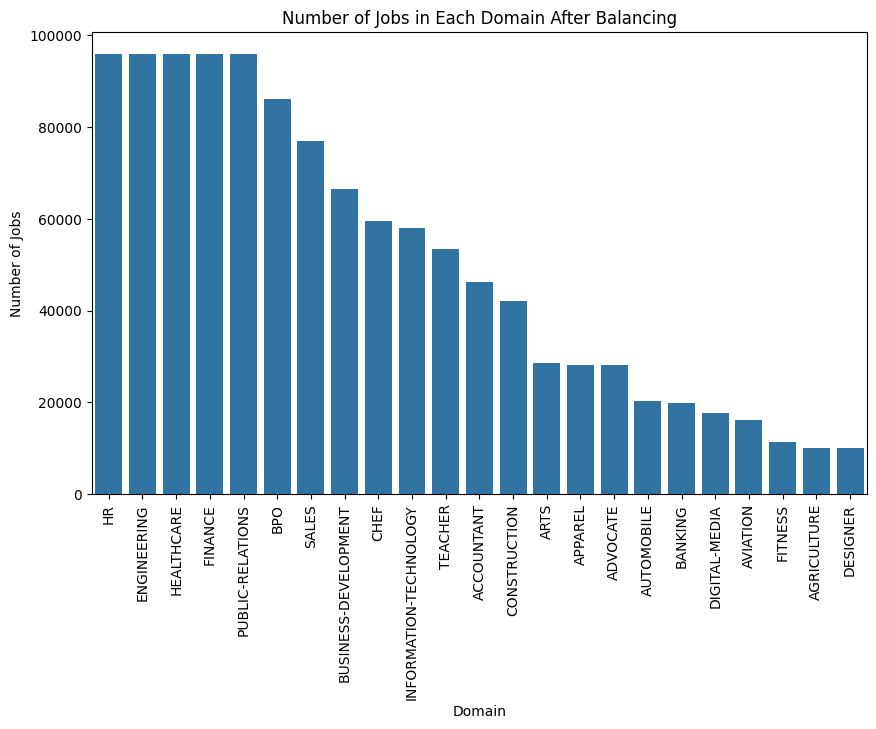

In [ ]:
# plot the distribution after sampling
plt.figure(figsize=(10, 6))
sns.barplot(x=after.index, y=after.values)
plt.title('Number of Jobs in Each Domain After Balancing')
plt.xlabel('Domain')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=90)
plt.show()

In [ ]:
def balance_job_distribution_unique(df, jobs_df, random_state=42):
    """
    Balance job distribution ensuring different users interact with different jobs (one-to-one).
    Each job assigned to only one user.
    """
    np.random.seed(random_state)

    dist_before = df['job_domain'].value_counts()
    target_count = dist_before.min()   # strict equalization

    balanced_parts = []

    for domain, count in dist_before.items():
        domain_df = df[df['job_domain'] == domain].copy()

        if count > target_count:
            # Downsample
            sampled = domain_df.sample(n=target_count, random_state=random_state)
            balanced_parts.append(sampled)

        else:
            needed = target_count - count

            candidate_jobs = jobs_df[jobs_df['parent_domain'] == domain][['job_id','parent_domain']].drop_duplicates()
            candidate_jobs = candidate_jobs.rename(columns={'parent_domain':'job_domain'})

            domain_users = list(domain_df['user_id'].unique())
            np.random.shuffle(domain_users)

            # Ensure one-to-one: pick min(#users, #jobs, needed)
            job_ids = candidate_jobs['job_id'].unique()
            add_n = min(needed, len(job_ids), len(domain_users))

            add_jobs = np.random.choice(job_ids, size=add_n, replace=False)
            add_users = np.random.choice(domain_users, size=add_n, replace=False)

            new_df = pd.DataFrame({
                'user_id': add_users,
                'job_id': add_jobs,
                'label': 1,
                'job_domain': domain
            })

            domain_df = pd.concat([domain_df, new_df], ignore_index=True)
            balanced_parts.append(domain_df)

    balanced_df = pd.concat(balanced_parts, ignore_index=True).drop_duplicates(subset=['user_id','job_id'])
    dist_after = balanced_df['job_domain'].value_counts()

    return balanced_df, dist_before, dist_after


In [ ]:
strict_df,before,after = balance_job_distribution_unique(df, jobs_df)

In [ ]:
strict_df['job_domain'].value_counts()

,count
job_domain,
HR,9198
ENGINEERING,9198
HEALTHCARE,9198
FINANCE,9198
PUBLIC-RELATIONS,9198
BPO,9198
SALES,9198
BUSINESS-DEVELOPMENT,9198
INFORMATION-TECHNOLOGY,9198


In [ ]:
# load job_id to id mapping
with open('/content/drive/MyDrive/job_id_to_id_mapping.pkl', 'rb') as f:
    job_id_to_id = pickle.load(f)
strict_df['job_id'] = strict_df['job_id'].map(job_id_to_id)
strict_df.head()

,user_id,job_id,label,job_domain
0,25150191,42749,1,HR
1,80162314,60972,1,HR
2,91930382,35667,1,HR
3,44476983,34151,1,HR
4,15575117,34200,1,HR


In [ ]:
job_embed_dict,resume_embed_dict = None,None

with open('/content/drive/MyDrive/job_embed_dict.pkl', 'rb') as f:
    job_embed_dict = pickle.load(f)

with open('/content/drive/MyDrive/resume_embed_dict.pkl', 'rb') as f:
    resume_embed_dict = pickle.load(f)

In [ ]:
strict_df['user_embed'] = strict_df['user_id'].map(resume_embed_dict)
strict_df['job_embed'] = strict_df['job_id'].map(job_embed_dict)
strict_df.head()

,user_id,job_id,label,job_domain,user_embed,job_embed
0,25150191,42749,1,HR,"[-0.005237032, -0.01750603, -0.022287546, -0.0...","[-0.02687, -0.01319, -0.0372, -0.00739, -0.015..."
1,80162314,60972,1,HR,"[-0.0021862907, -0.009142388, -0.037046235, 0....","[-0.007275, -0.01987, -0.02298, 0.02856, -0.00..."
2,91930382,35667,1,HR,"[-0.023359412, -0.025879702, -0.021596568, -0....","[-0.0252, 0.005714, -0.0364, 0.00643, 0.001748..."
3,44476983,34151,1,HR,"[-0.0037473843, -0.007885832, -0.021464543, 0....","[-0.0182, -0.00471, -0.02684, 0.0371, -0.01263..."
4,15575117,34200,1,HR,"[-0.009734568, -0.022199256, -0.02904904, -0.0...","[0.014824, 0.01697, -0.038, 0.00935, -0.01171,..."


In [ ]:
strict_df['user_embed'].iloc[0].shape

(1024,)

In [ ]:
balanced_df['job_id'] = balanced_df['job_id'].map(job_id_to_id)
balanced_df['user_embed'] = balanced_df['user_id'].map(resume_embed_dict)
balanced_df['job_embed'] = balanced_df['job_id'].map(job_embed_dict)
balanced_df.head()

,user_id,job_id,label,job_domain,user_embed,job_embed
0,25150191,42749,1,HR,"[-0.005237032, -0.01750603, -0.022287546, -0.0...","[-0.02687, -0.01319, -0.0372, -0.00739, -0.015..."
1,80162314,60972,1,HR,"[-0.0021862907, -0.009142388, -0.037046235, 0....","[-0.007275, -0.01987, -0.02298, 0.02856, -0.00..."
2,91930382,35667,1,HR,"[-0.023359412, -0.025879702, -0.021596568, -0....","[-0.0252, 0.005714, -0.0364, 0.00643, 0.001748..."
3,44476983,34151,1,HR,"[-0.0037473843, -0.007885832, -0.021464543, 0....","[-0.0182, -0.00471, -0.02684, 0.0371, -0.01263..."
4,15575117,34200,1,HR,"[-0.009734568, -0.022199256, -0.02904904, -0.0...","[0.014824, 0.01697, -0.038, 0.00935, -0.01171,..."


In [ ]:
strict_df['combined_embedding'] = strict_df['user_embed'] + strict_df['job_embed']
strict_df.head()

,user_id,job_id,label,job_domain,user_embed,job_embed,combined_embedding
0,25150191,42749,1,HR,"[-0.005237032, -0.01750603, -0.022287546, -0.0...","[-0.02687, -0.01319, -0.0372, -0.00739, -0.015...","[-0.03210776, -0.030697253, -0.059488475, -0.0..."
1,80162314,60972,1,HR,"[-0.0021862907, -0.009142388, -0.037046235, 0....","[-0.007275, -0.01987, -0.02298, 0.02856, -0.00...","[-0.009460919, -0.029009331, -0.06002597, 0.03..."
2,91930382,35667,1,HR,"[-0.023359412, -0.025879702, -0.021596568, -0....","[-0.0252, 0.005714, -0.0364, 0.00643, 0.001748...","[-0.04856693, -0.020165285, -0.058004037, -0.0..."
3,44476983,34151,1,HR,"[-0.0037473843, -0.007885832, -0.021464543, 0....","[-0.0182, -0.00471, -0.02684, 0.0371, -0.01263...","[-0.02195112, -0.012596983, -0.04830475, 0.048..."
4,15575117,34200,1,HR,"[-0.009734568, -0.022199256, -0.02904904, -0.0...","[0.014824, 0.01697, -0.038, 0.00935, -0.01171,...","[0.0050893454, -0.005231483, -0.06704342, 0.00..."


In [ ]:
import gc
del resume_embed_dict, job_embed_dict,df, jobs_df, resume_df
gc.collect()

14866

In [ ]:
drop_cols = ['user_id','job_id','user_embed','job_embed','label']
strict_df = strict_df.drop(drop_cols,axis=1)
strict_df.head()

,job_domain,combined_embedding
0,HR,"[-0.03210776, -0.030697253, -0.059488475, -0.0..."
1,HR,"[-0.009460919, -0.029009331, -0.06002597, 0.03..."
2,HR,"[-0.04856693, -0.020165285, -0.058004037, -0.0..."
3,HR,"[-0.02195112, -0.012596983, -0.04830475, 0.048..."
4,HR,"[0.0050893454, -0.005231483, -0.06704342, 0.00..."


In [ ]:
# save the strict_df to drive in parquet format
strict_df.to_parquet('/content/drive/MyDrive/strict_df.parquet')

In [ ]:
balanced_df['combined_embedding'] = balanced_df['user_embed'] + balanced_df['job_embed']
drop_cols = ['user_id','job_id','user_embed','job_embed','label']
balanced_df = balanced_df.drop(drop_cols,axis=1)
balanced_df.head()

,job_domain,combined_embedding
0,HR,"[-0.03210776, -0.030697253, -0.059488475, -0.0..."
1,HR,"[-0.009460919, -0.029009331, -0.06002597, 0.03..."
2,HR,"[-0.04856693, -0.020165285, -0.058004037, -0.0..."
3,HR,"[-0.02195112, -0.012596983, -0.04830475, 0.048..."
4,HR,"[0.0050893454, -0.005231483, -0.06704342, 0.00..."


# **model**

In [ ]:
# train,test and validation split
train_df, test_df = train_test_split(strict_df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.5, random_state=42)

In [ ]:
class JobDomainDataset(Dataset):
    def __init__(self, dataframe, label_encoder):
        self.labels = label_encoder.transform(dataframe['job_domain'])
        self.embeddings = torch.tensor(np.vstack(dataframe['combined_embedding'].values), dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# Instantiate the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(strict_df['job_domain'])

# Create Dataset instances
train_dataset = JobDomainDataset(train_df, label_encoder)
val_dataset = JobDomainDataset(val_df, label_encoder)
test_dataset = JobDomainDataset(test_df, label_encoder)

# Define batch size
batch_size = 64

# Create DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 74043
Number of validation samples: 74044
Number of test samples: 63467


In [ ]:
class JobDomainClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.3):
        super(JobDomainClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Get input dimension from embeddings
input_dim = train_dataset.embeddings.shape[1]
num_classes = len(label_encoder.classes_)

model = JobDomainClassifier(input_dim=input_dim, hidden_dim=256, num_classes=num_classes)
print(model)

JobDomainClassifier(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=23, bias=True)
  )
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

JobDomainClassifier(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=23, bias=True)
  )
)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_job_domain_model.pth")

    print("Training completed.")

In [ ]:
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=10)

Epoch [1/10] Train Loss: 1.4366, Train Acc: 0.5620, Val Acc: 0.8038
Epoch [2/10] Train Loss: 0.6926, Train Acc: 0.7867, Val Acc: 0.8692
Epoch [3/10] Train Loss: 0.5245, Train Acc: 0.8405, Val Acc: 0.8982
Epoch [4/10] Train Loss: 0.4260, Train Acc: 0.8686, Val Acc: 0.9146
Epoch [5/10] Train Loss: 0.3641, Train Acc: 0.8870, Val Acc: 0.9270
Epoch [6/10] Train Loss: 0.3190, Train Acc: 0.9004, Val Acc: 0.9387
Epoch [7/10] Train Loss: 0.2827, Train Acc: 0.9119, Val Acc: 0.9480
Epoch [8/10] Train Loss: 0.2544, Train Acc: 0.9201, Val Acc: 0.9483
Epoch [9/10] Train Loss: 0.2349, Train Acc: 0.9268, Val Acc: 0.9579
Epoch [10/10] Train Loss: 0.2201, Train Acc: 0.9300, Val Acc: 0.9611
Training completed.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
def evaluate_model(model, test_loader, label_encoder):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
    print(f"Test Accuracy: {acc:.4f}")
    print(report)

In [ ]:
# Load best model and evaluate
model.load_state_dict(torch.load("best_job_domain_model.pth"))
evaluate_model(model, test_dataloader, label_encoder)

Test Accuracy: 0.9596
                        precision    recall  f1-score   support

            ACCOUNTANT       0.98      0.99      0.98      2742
              ADVOCATE       0.99      0.96      0.97      2756
           AGRICULTURE       0.97      0.98      0.97      2788
               APPAREL       0.95      0.94      0.94      2677
                  ARTS       0.93      0.96      0.94      2745
            AUTOMOBILE       0.98      0.96      0.97      2793
              AVIATION       0.96      1.00      0.98      2796
               BANKING       0.98      0.98      0.98      2778
                   BPO       0.96      0.97      0.97      2706
  BUSINESS-DEVELOPMENT       0.97      0.94      0.96      2803
                  CHEF       0.98      0.96      0.97      2773
          CONSTRUCTION       0.98      0.97      0.97      2795
              DESIGNER       0.98      0.99      0.99      2726
         DIGITAL-MEDIA       0.97      0.88      0.92      2824
           ENGINE

In [ ]:
torch.save({
    "model_state": model.state_dict(),
    "label_encoder": label_encoder.classes_,
    "input_dim": input_dim,
    "num_classes": num_classes
}, "final_job_domain_model.pth")

print("Model saved as final_job_domain_model.pth")

Model saved as final_job_domain_model.pth


# **Inferencing**

In [ ]:
class JobDomainClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.3):
        super(JobDomainClassifier, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim, hidden_dim // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def predict_topk(model, embedding, label_encoder, k=3):
    """
    Predict top-k job domains for a given embedding.

    Args:
        model (nn.Module): trained model
        embedding (np.array or torch.tensor): job embedding (1D vector)
        label_encoder (LabelEncoder): fitted label encoder
        k (int): number of top predictions

    Returns:
        List of (domain, probability) tuples
    """
    model.eval()
    device = next(model.parameters()).device

    # Convert embedding to tensor
    if isinstance(embedding, np.ndarray):
        embedding = torch.tensor(embedding, dtype=torch.float32)
    if embedding.ndim == 1:
        embedding = embedding.unsqueeze(0)  # shape (1, dim)

    embedding = embedding.to(device)

    with torch.no_grad():
        outputs = model(embedding)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_idxs = torch.topk(probs, k=k)

    top_probs = top_probs.cpu().numpy().flatten()
    top_idxs = top_idxs.cpu().numpy().flatten()

    # Map back to domain names
    top_domains = label_encoder.inverse_transform(top_idxs)

    return list(zip(top_domains, top_probs))

In [ ]:
# Load model
checkpoint = torch.load("/content/final_job_domain_model.pth", map_location="cpu", weights_only=False)

# Rebuild model
model = JobDomainClassifier(input_dim=checkpoint["input_dim"], hidden_dim=256, num_classes=checkpoint["num_classes"])
model.load_state_dict(checkpoint["model_state"])
model.eval()

# Define label_encoder
label_encoder = LabelEncoder()
label_encoder.classes_ = checkpoint["label_encoder"]

# Example: take one embedding from test_df
sample_embedding = np.array(balanced_df.iloc[1111150]["combined_embedding"])

# Predict top 3 domains
results = predict_topk(model, sample_embedding, label_encoder, k=3)
print("Top-3 Predictions:")
for domain, prob in results:
    print(f"{domain}: {prob:.4f}")

Top-3 Predictions:
DIGITAL-MEDIA: 0.9504
PUBLIC-RELATIONS: 0.0380
ARTS: 0.0075


In [ ]:
balanced_df[balanced_df['job_domain']=='DIGITAL-MEDIA']

,job_domain,combined_embedding
1093532,DIGITAL-MEDIA,"[-0.006286173, -0.018957479, -0.041785464, 0.0..."
1093533,DIGITAL-MEDIA,"[-0.020730525, -0.031761512, -0.044440493, -0...."
1093534,DIGITAL-MEDIA,"[-0.0264602, -0.035873756, -0.04964374, -0.041..."
1093535,DIGITAL-MEDIA,"[-0.023675472, -0.0029376578, -0.056754336, 0...."
1093536,DIGITAL-MEDIA,"[-0.031449825, -0.028725011, -0.042380556, 0.0..."
...,...,...
1111148,DIGITAL-MEDIA,"[-0.031159414, 0.012087742, -0.042787068, 0.01..."
1111149,DIGITAL-MEDIA,"[0.008469783, 0.007698487, -0.07473785, 0.0084..."
1111150,DIGITAL-MEDIA,"[-0.022358906, -0.0047478266, -0.06452669, 0.0..."
1111151,DIGITAL-MEDIA,"[-0.017559938, -0.002856017, -0.05108363, 0.00..."


In [ ]:
# get any random embedding from each domain and map it
domain_embed_map = {}

for domain in label_encoder.classes_:
  domain_embed_map[domain] = np.array(balanced_df[balanced_df['job_domain']==domain].iloc[0]['combined_embedding'])

In [ ]:
# save that dictionary
import pickle

with open('/content/drive/MyDrive/domain_embed_map.pkl', 'wb') as f:
    pickle.dump(domain_embed_map, f)